<a href="https://colab.research.google.com/github/kmsrogerkim/HAI-Intro-to-Torch/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch import nn

# For train dataset
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Make Train Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
latent_dim = 100
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    # Define the Generator's architecture
    self.model = nn.Sequential(
        nn.Linear(latent_dim, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 28*28),
        nn.Tanh()
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # Define the Discriminator's architecture
    self.model = nn.Sequential(
      nn.Linear(28*28, 1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(1024, 512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
# Loss function
criterion = nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

lr = 0.00021

# Optimizers
G_optimizer = torch.optim.Adam(generator.model.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(discriminator.model.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
import torch.autograd as autograd

num_epochs = 30
# Tries to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
criterion.to(device)

# Training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Flatten the images for the Discriminator
        images = images.view(images.size(0), -1).to(device)

        # Real labels are 1, fake labels are 0
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        ############################
        # Train the Discriminator
        ############################
        D_optimizer.zero_grad()

        # Compute BCELoss using real images
        outputs = discriminator(images)
        D_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Generate fake images
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(z)

        # Compute BCELoss using fake images
        outputs = discriminator(fake_images.detach())
        D_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Optimize the Discriminator
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optimizer.step()

        ############################
        # Train the Generator
        ############################
        G_optimizer.zero_grad()

        # Generate fake images
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(z)

        # Compute BCELoss using fake images, with reversed labels
        outputs = discriminator(fake_images)
        G_loss = criterion(outputs, real_labels)

        # Optimize the Generator
        G_loss.backward()
        G_optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], D_loss: {:.4f}, G_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), D_loss.item(), G_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

Epoch [1/30], Step [100/938], D_loss: 1.1961, G_loss: 0.8637, D(x): 0.60, D(G(z)): 0.49
Epoch [1/30], Step [200/938], D_loss: 0.7472, G_loss: 1.1601, D(x): 0.92, D(G(z)): 0.47
Epoch [1/30], Step [300/938], D_loss: 0.5604, G_loss: 2.7107, D(x): 0.90, D(G(z)): 0.33
Epoch [1/30], Step [400/938], D_loss: 0.2075, G_loss: 3.4950, D(x): 0.91, D(G(z)): 0.09
Epoch [1/30], Step [500/938], D_loss: 0.5521, G_loss: 1.7113, D(x): 0.73, D(G(z)): 0.17
Epoch [1/30], Step [600/938], D_loss: 1.1649, G_loss: 5.1491, D(x): 0.96, D(G(z)): 0.63
Epoch [1/30], Step [700/938], D_loss: 0.7938, G_loss: 2.9565, D(x): 0.68, D(G(z)): 0.05
Epoch [1/30], Step [800/938], D_loss: 1.2344, G_loss: 1.2835, D(x): 0.59, D(G(z)): 0.13
Epoch [1/30], Step [900/938], D_loss: 0.6985, G_loss: 2.6242, D(x): 0.71, D(G(z)): 0.03
Epoch [2/30], Step [100/938], D_loss: 0.3454, G_loss: 2.8011, D(x): 0.84, D(G(z)): 0.06
Epoch [2/30], Step [200/938], D_loss: 0.7463, G_loss: 2.2929, D(x): 0.66, D(G(z)): 0.03
Epoch [2/30], Step [300/938], D_

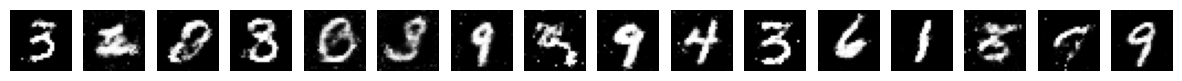

In [ ]:
# Generate fake images for visualization
z = torch.randn(16, latent_dim).to(device)
fake_images = generator(z)
fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
fake_images = (fake_images + 1) / 2  # Rescale images to [0, 1]

# Plot the fake images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 16, figsize=(15, 15))
for ax, img in zip(axes.flatten(), fake_images):
    ax.axis('off')
    ax.set_adjustable('box')
    img = transforms.ToPILImage()(img.cpu().squeeze())
    ax.imshow(img, cmap='gray')
plt.show()